<a href="https://colab.research.google.com/github/GParolini/colabs_am_bib/blob/master/2Bib_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Content of the notebook

This notebook has been created to analyse the bibliographic data extracted from the *Second Bibliography of Literature on Agricultural Meteorology* published by the British Ministry of Agriculture and Fisheries in 1936. The data in the bibliography only refer to publications printed in the 1920s-early 1930s. Manual ETL with checks done as part of the project "Environmental Factors in Agriculture: Observation and Experiment in Agricultural Meteorology (ca 1900-1950)" (https://agriculturalmeteorology.wordpress.com).  The data analysis has been used in the preparation of an advanced review for the journal *WIREs Climate Change*. The data analysis work has been made possible with funding provided by the German Research Foundation (DFG), project No. 321660352.

#Module imports and styling of the notebook


In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
from google.colab import drive #to access data stored in Google drive
from google.colab import files #to save data in Google drive

import pandas as pd
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from collections import Counter
from collections import defaultdict
import glob
import re
from textwrap import wrap

import spacy.cli
from spacy.lang.en.stop_words import STOP_WORDS

from gensim import corpora
from gensim import models

from wordcloud import WordCloud


#Reading and cleaning data

In [3]:
"""
Data are stored in Google drive as csv file.
"""

drive.mount("/content/drive", force_remount=True) 

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/2_bib_data.csv")

In [5]:
#Avoid that the year of publication is displayed as a float
df["Publication Year"] = (df["Publication Year"].fillna(0)
    .astype(int)
    .astype(object)
    .where(df["Publication Year"].notnull())
    )

#Remove columns with scarce information
df = df.loc[:, df.isnull().mean() <= .97]

#Remove column with uniteresting information
df =df.drop(["Date Added", "Date Modified"], axis=1)

In [6]:
df.head(5)

,Key,Item Type,Publication Year,Author,Title,Publication Title,DOI,Url,Date,Pages,Issue,Volume,Publisher,Place,Language,Type,Archive,Extra,Manual Tags,Number
0,88Z3WKI8,journalArticle,1930,"Kincer, J. B.",Weather and cotton production,Monthly Weather Review,10.1175/1520-0493(1930)58<190:WACP>2.0.CO;2,https://journals.ametsoc.org/doi/abs/10.1175/1...,1930,190-196,5,58,NaN,NaN,English,NaN,WB 00824,2B_p39_4,clean,NaN
1,H2HWQY4H,journalArticle,1932,"Keen, B. A.",Soil physics in relation to meteorology,Quarterly Journal of the Royal Meteorological ...,10.1002/qj.49705824504,https://rmets.onlinelibrary.wiley.com/doi/abs/...,1932,229-250,245,58,NaN,NaN,English,NaN,NaN,2B_p52_9,Quarterly Journal of the Royal Meteorological ...,NaN
2,ZZXJVDB8,bookSection,1932,"Enquist, F.",Om klimatets inverkan på skördevariationer [Th...,Svensk Geografisk Årsbok [Swedish Geografical ...,NaN,NaN,1932,122-146,NaN,NaN,NaN,NaN,Swedish,NaN,NaN,2B_p56_12,"Institution; Sweden; Enquist, F.; Swedish Geog...",NaN
3,ZDF2SDR2,journalArticle,1932,"Koloskov, P. I.",The climate of soy-beans and the possible regi...,Izv. Daljn. Vost. Geofizin'a [Records of the F...,NaN,NaN,1932,5-74,2,9,NaN,NaN,Russian,NaN,NaN,2B_p57_8,"Koloskov, P. I.; Geophysics Observatory of the...",NaN
4,BZT555AP,journalArticle,1932,"Hecht, W.",Bioklimatische Versuche zur Erforschung der Ur...,Zeitschrift für Heil- und Gewürzpflanzen,NaN,NaN,1932,15–50,1-2,14,NaN,NaN,German,NaN,NaN,2B_p55_4,NaN,NaN


#Data inspection and visualisation

##Items

###Item types and count

In [7]:
item_types =list(set(df["Item Type"]))
print(item_types)

['bookSection', 'book', 'journalArticle', 'report', 'thesis']


In [8]:
count_item_types = df["Item Type"].value_counts()
print(count_item_types)

journalArticle    514
report             35
bookSection        27
book               16
thesis              1
Name: Item Type, dtype: int64


###Items listed per type

###Journal articles


In [9]:
#Listing items per type helps in cleaning further the data (e.g. eliminate typos and inconsistencies in journal titles)

articles = df.loc[df["Item Type"] == "journalArticle"]
journ_titles = articles["Publication Title"].dropna()
journ_titles_unique = list(set(journ_titles))
sorted_journ_titles = sorted(journ_titles_unique)


with open('2Bib_journal_titles.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_journ_titles))


####Popular publication outlets (journals)

In [10]:
journals = sorted_journ_titles

my_list = []
no_art = df.loc[df["Item Type"] == "journalArticle"].groupby(["Publication Title"]).size()
my_dict = {k: v for k, v in zip(journals,no_art)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

one_art_journ = Counter(my_dict.values())[1]

print("In", one_art_journ, "journals only one article was published")

with open('2Bib_journal_art_dict.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, ensure_ascii=False, indent=2)

In 119 journals only one article was published


###Reports

In [11]:
reports = df.loc[df["Item Type"] == "report"]
rep_titles = reports["Type"].dropna()
rep_titles_unique = list(set(rep_titles))
sorted_rep_titles = sorted(rep_titles_unique)

with open('2Bib_report_titles.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_rep_titles))

###Books

In [12]:
books = df.loc[df["Item Type"] == "book"]
book_titles = books["Title"].dropna()
book_titles_unique = list(set(book_titles))
sorted_book_titles = sorted(book_titles_unique)

with open('2Bib_book_titles.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_book_titles))

###Book chapters

In [13]:
book_sections = df.loc[df["Item Type"] == "bookSection"]
book_sec_titles = book_sections["Publication Title"].dropna()
book_sec_titles_unique = list(set(book_sec_titles))
sorted_book_sec_titles = sorted(book_sec_titles_unique)

with open('2Bib_book_sec_titles.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_book_sec_titles))

###Theses

In [14]:
theses = df.loc[df["Item Type"] == "thesis"]
thesis_titles = theses["Title"].dropna()
thesis_titles_unique = list(set(thesis_titles))
sorted_thesis_titles = sorted(thesis_titles_unique)

with open('2Bib_thesis_titles.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_thesis_titles))

##Languages included in the data set and their popularity

In [15]:
lang_counts = df["Language"].value_counts()
print(lang_counts)

English         345
German           92
French           68
Russian          38
Italian          22
Swedish           6
Japanese          5
Norwegian         4
Czechoslovak      4
Hungarian         2
Dutch             2
Spanish           2
Chinese           1
Finnish           1
Polish            1
Name: Language, dtype: int64


##Distribution of the publications over time

In [16]:
df["Publication Year"]=pd.to_numeric(df["Publication Year"])
years = [x for x in range (1900, 1951)]
no_publications = df.groupby(["Publication Year"]).size().tolist()
my_dict = {k: v for k, v in zip(years,no_publications)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

with open('2Bib_years_dict.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, indent=2)


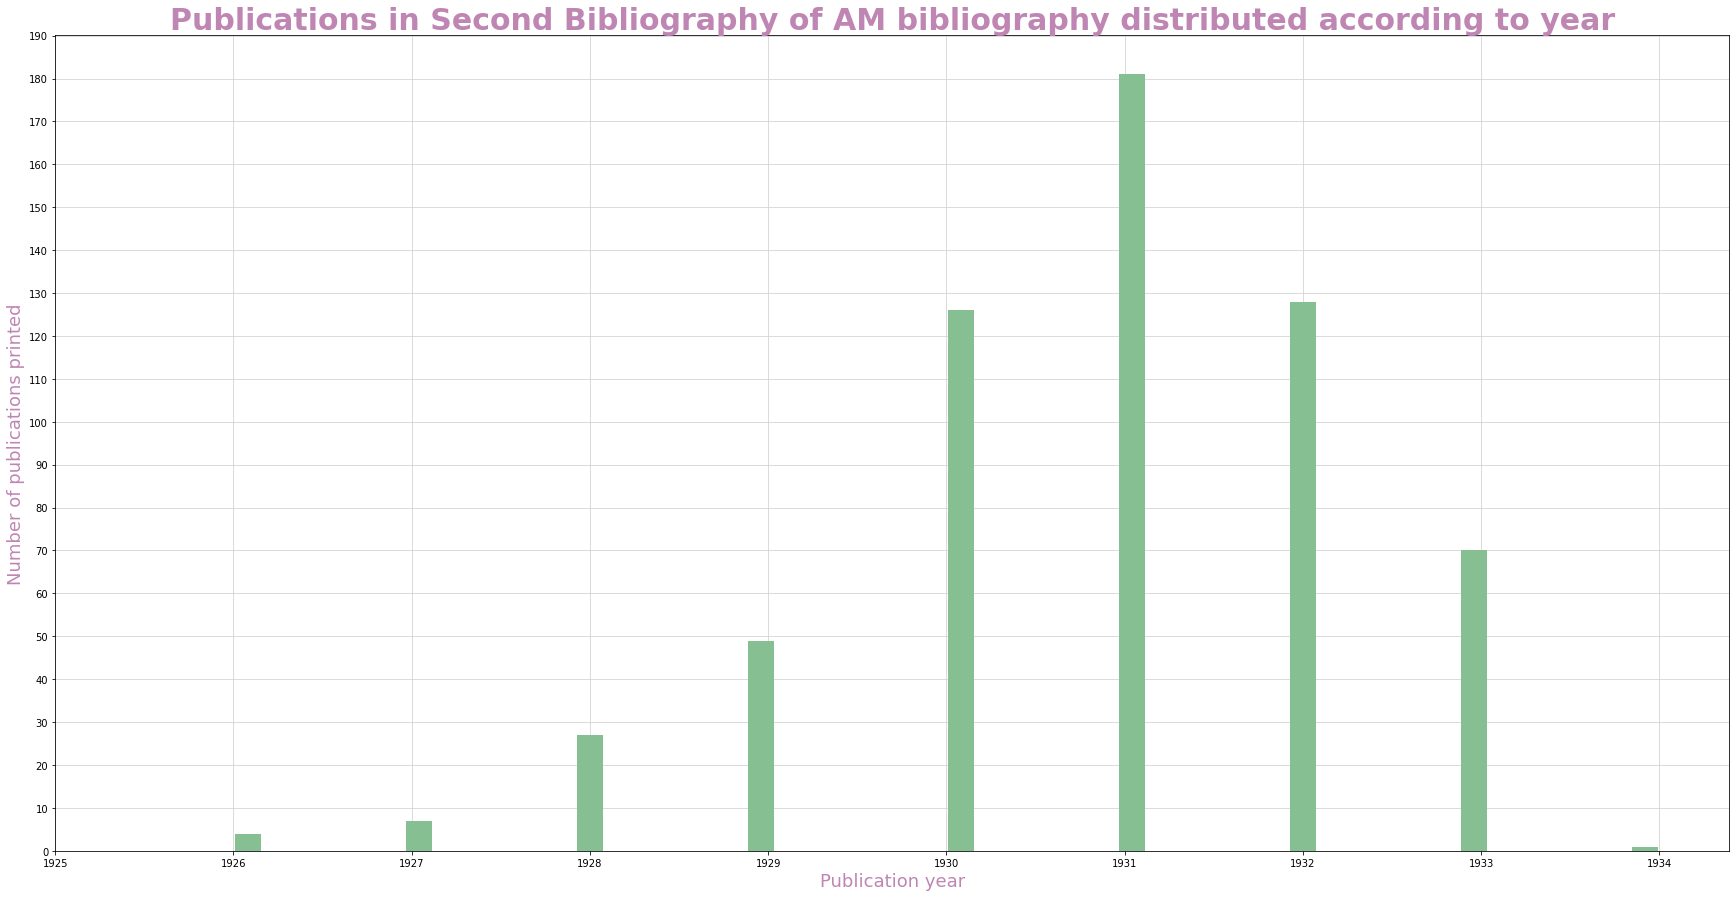

In [17]:
#histogram
ax = df.hist(column="Publication Year", bins=50, grid=False, figsize=(30,15), 
             color='#86bf91', zorder=2, rwidth=0.9)
#title
plt.title("Publications in Second Bibliography of AM bibliography distributed according to year",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})
#ticks
plt.xlabel('Publication year', fontsize=18, color ="#bf86b4")
plt.xticks(list(range(1925, 1935, 1))) 
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.ylabel('Number of publications printed',
           fontsize=18, color ="#bf86b4" )
plt.yticks(list(range(0, 200, 10)))
plt.rc('ytick',labelsize=20, color ="#bf86b4")

#grid
plt.grid(True,color="#D3D3D3")

#save to file
plt.savefig("2Bib_publications_per_year")

##Distribution of the publications per language

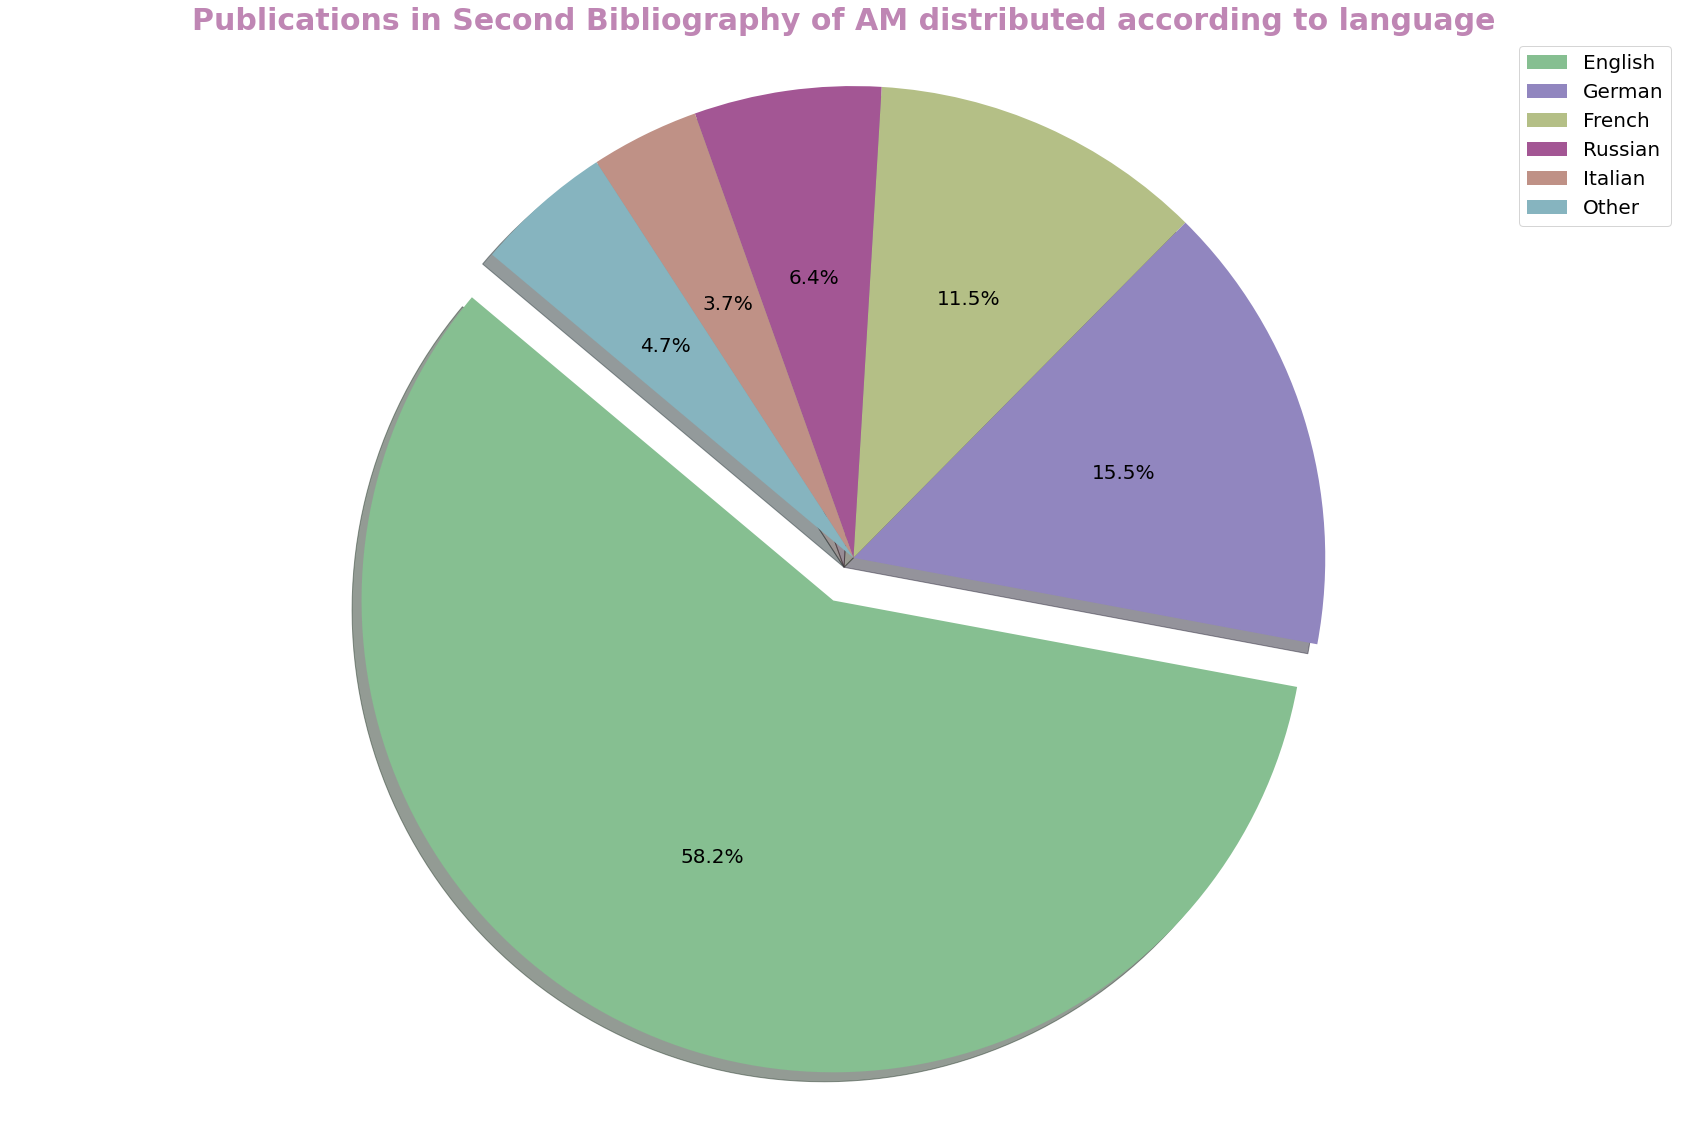

In [30]:
lang_list = sorted(list(set(df["Language"].tolist())))
lang_counts = df.groupby(["Language"]).size()
list_lang_counts = df.groupby(["Language"]).size().tolist()
my_dict = {k: v for k, v in zip(lang_list,list_lang_counts)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)
#my_dict1 is the dictionary that contains all the languages in the data set and the count of the publications in each language
with open('2Bib_lang_dict.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, ensure_ascii=False, indent=2)

"""
There are over twenty languages in the dictionary, but only 5-6 can be displayed clearly in a pie chart.
For clarity's sake, therefore, I kept only the five main languages and grouped all the others
"""

list_main_lang = my_dict1[0:5]
list_other = my_dict1[5:]
other_count = []
for item in list_other:
  other_count.append(item[1])
other_sum = sum(other_count)
my_list_other = [("Other", other_sum)]
lang_list_pie_plot = list_main_lang + my_list_other

#generation of the pie chart
languages = [x[0] for x in lang_list_pie_plot]
counts = [x[1] for x in lang_list_pie_plot]
plt.figure(figsize=(30,20))      
explode = (0.1,0,0,0,0,0)
plt.pie(counts, explode, 
            autopct='%1.1f%%', shadow=True, startangle=140)
cmap = mcolors.ListedColormap(["#86bf91", "#9186bf", "#b4bf86", "#a35694", "#bf9186","#86b4bf"])
plt.cycler("color", cmap.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color',["#86bf91", "#9186bf", "#b4bf86", "#a35694", "#bf9186","#86b4bf"])
plt.rcParams['font.size'] = 20
plt.title("Publications in Second Bibliography of AM distributed according to language", 
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})
plt.legend(loc="best", labels=languages )
plt.axis('equal')

#save to file
plt.savefig("2Bib_publications_per_language")

##Complete list of authors cited in the bibliography

In [19]:
def get_all_authors(df):
    reshaped = \
    (df.set_index(df.columns.drop("Author",1).tolist())
    .Author.str.split('; ', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'Author'})
    .loc[:, df.columns]
    )
    authors = reshaped["Author"].dropna()
    authors1 = authors.str.strip(" ")
    authors_noduplicates = list(set(authors1))
    return sorted(authors_noduplicates)

my_authors = get_all_authors(df)

with open('2Bib_authors.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(my_authors))

###Number of publications for each author

In [20]:
def author_counts(df):
    reshaped = \
    (df.set_index(df.columns.drop("Author",1).tolist())
    .Author.str.split('; ', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'Author'})
    .loc[:, df.columns])
    authors = reshaped["Author"].dropna()
    authors1 = authors.str.strip(" ")
    count = Counter(authors1)
    my_dict1 = sorted(count.items(), key=lambda x: x[1], reverse=True)
    
    return my_dict1

publications_per_author = author_counts(df)

with open('2Bib_publications_per_author.json', 'w', encoding='utf-8') as f:
    json.dump(publications_per_author, f, ensure_ascii=False, indent=2)


###Histogram of the publications per author

No. of authors who published 8 papers: 1
No. of authors who published 6 papers: 1
No. of authors who published 5 papers: 2
No. of authors who published 4 papers: 3


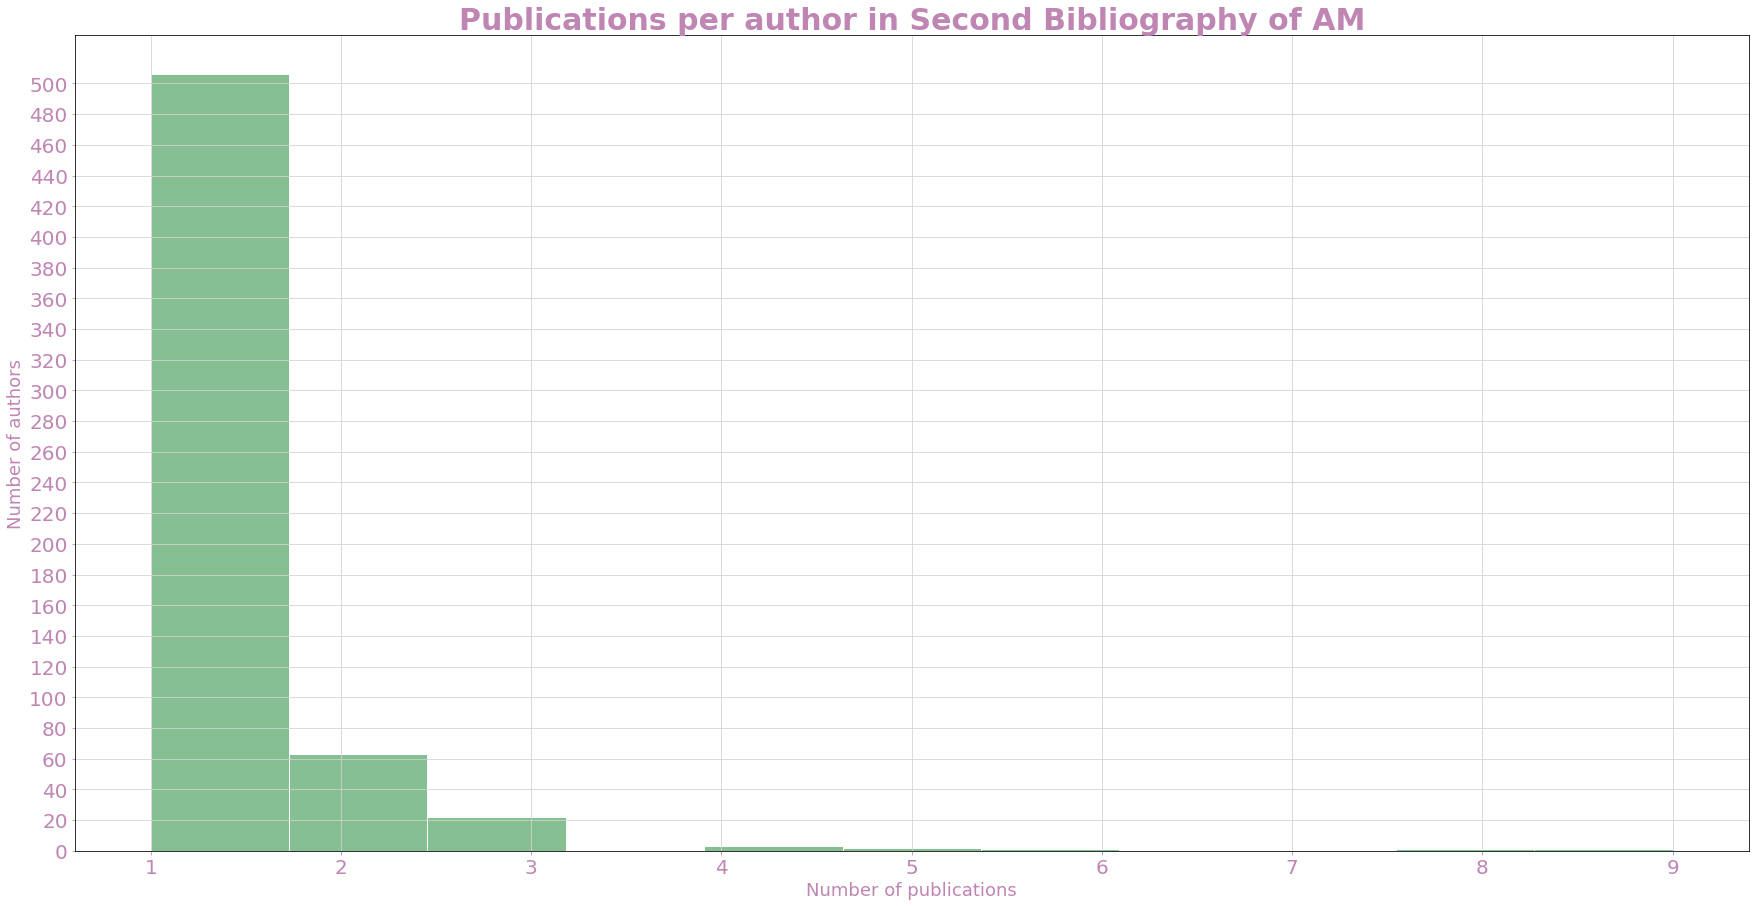

In [21]:

#No. of authors who published 8 papers
my_list_8 = list(filter(lambda x: (x[1] == 8), publications_per_author))
counts_8 = []
for tup in my_list_8:
  counts_8.append(tup[1])
authors_8_papers =len(counts_8)
print("No. of authors who published 8 papers: " + str(authors_8_papers))

#No. of authors who published 6 papers
my_list_6 = list(filter(lambda x: (x[1] == 6), publications_per_author))
counts_6 = []
for tup in my_list_6:
  counts_6.append(tup[1])
authors_6_papers =len(counts_6)
print("No. of authors who published 6 papers: " + str(authors_6_papers))

#No. of authors who published 5 papers
my_list_5 = list(filter(lambda x: (x[1] == 5), publications_per_author))
counts_5 = []
for tup in my_list_5:
  counts_5.append(tup[1])
authors_5_papers =len(counts_5)
print("No. of authors who published 5 papers: " + str(authors_5_papers))

#No. of authors who published 4 papers
my_list_4 = list(filter(lambda x: (x[1] == 4), publications_per_author))
counts_4 = []
for tup in my_list_4:
  counts_4.append(tup[1])
authors_4_papers =len(counts_4)
print("No. of authors who published 4 papers: " + str(authors_4_papers))

counts = []
for tup in publications_per_author:
  counts.append(tup[1])

#histogram
plt.figure(figsize=(30,15))
ax = plt.hist(counts, bins='auto', color='#86bf91', edgecolor = 'white', label='hst')

#title
plt.title("Publications per author in Second Bibliography of AM",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})

#ticks
plt.xlabel('Number of publications', fontsize=18, color ="#bf86b4")
plt.xticks(list(range(1, 10, 1))) 
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.ylabel('Number of authors',
           fontsize=18, color ="#bf86b4")
plt.yticks(list(range(0, 510, 20))) 
plt.rc('ytick',labelsize=20, color ="#bf86b4")

#grid
plt.grid(True,color="#D3D3D3")

#save to file
plt.savefig("2Bib_publications_per_author")


##Themes

In [22]:
#loading Spacy and it English model
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"=","inch","+","°","p.","possible","cent","c"}

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [23]:
#Get all the titles of the publications in English

eng_pub = df.loc[df['Language'] == 'English']

tit_eng_pub = list(eng_pub["Title"])

token_list = []
for item in tit_eng_pub:
  my_doc = nlp(item)
  for token in my_doc:
    token_list.append(token)

In [24]:
#Clean the tokens

for token in token_list:
    re.sub(r"[^a-zA-Z.!?]", "", str(token))
    re.sub(r"\d+", "", str(token))
    re.sub(r'\b\w{1,2}\b', '', str(token))

my_tokens_no_space = [token for token in token_list if token]
clean_tokens = [token for token in my_tokens_no_space if len(token)>2]


In [25]:
#Generate the lemmas from the tokens

lemmas = [token.lemma_ for token in clean_tokens]

stopwords = spacy.lang.en.stop_words.STOP_WORDS

#delete stopwords
my_lemmas_no_stopwords = [lemma for lemma in lemmas if lemma not in stopwords]

#delete pronouns
my_lemmas_no_pron = [lemma for lemma in my_lemmas_no_stopwords if lemma != '-PRON-']

In [26]:
#Counting the lemmas

lemma_counts = Counter(my_lemmas_no_pron)
lemma_dict = sorted(lemma_counts.items(), key=lambda x: x[1], reverse=True)

with open('2Bib_lemmas.json', 'w', encoding='utf-8') as f:
    json.dump(lemma_dict, f, ensure_ascii=False, indent=2)

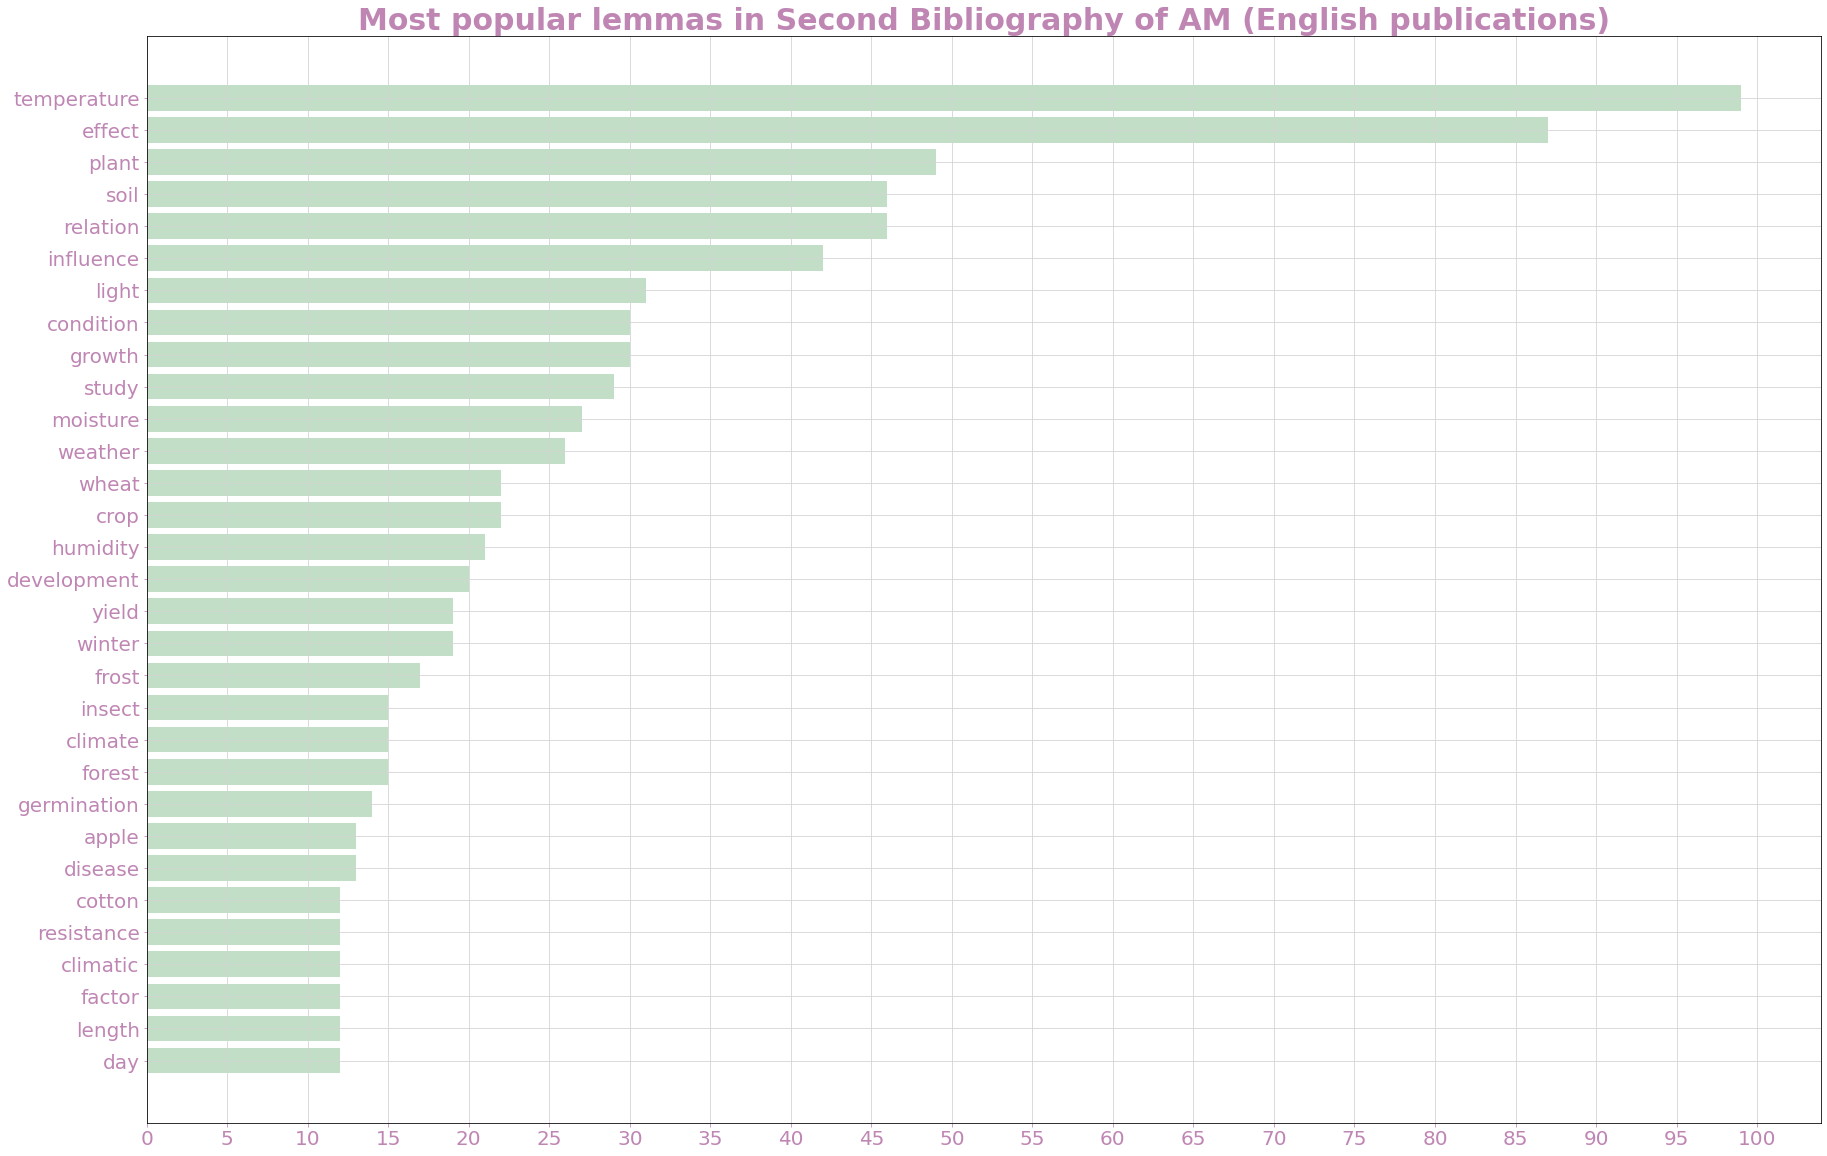

In [27]:
#Visualising the most popular lemmas

pop_lemma_dict = lemma_dict[0:31]

lemmas = [x[0] for x in pop_lemma_dict]
counts = [x[1] for x in pop_lemma_dict]

my_lemmas_uniq = list(set(my_lemmas_no_pron))

#bar plot
plt.figure(figsize=(30,20))
plt.barh(lemmas, counts, align='center', alpha=0.5, color='#86bf91')
plt.gca().invert_yaxis()

#title
plt.title("Most popular lemmas in Second Bibliography of AM (English publications)",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})

#grid
plt.grid(True,color="#D3D3D3")

#ticks
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.rc('ytick',labelsize=20, color ="#bf86b4")
plt.xticks(list(range(0, 105, 5)))

#save to file
plt.savefig("2Bib_popular_lemmas")



In [28]:
"""
Tentative topic modelling with Gensim.
Data are too few to consider the results more than a rough approssimation
"""
tokens_list = [lemma for lemma in lemmas if lemma not in stopwords]
texts = [token.split() for token in tokens_list]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]



model = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=30)
 
topics = model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.075*"growth" + 0.075*"apple" + 0.075*"day" + 0.075*"wheat" + 0.075*"factor" + 0.075*"cotton" + 0.075*"study" + 0.075*"influence" + 0.075*"yield" + 0.015*"effect"')
(1, '0.079*"resistance" + 0.079*"light" + 0.079*"crop" + 0.079*"germination" + 0.079*"climate" + 0.079*"winter" + 0.079*"soil" + 0.079*"relation" + 0.016*"effect" + 0.016*"length"')
(2, '0.106*"frost" + 0.106*"forest" + 0.106*"moisture" + 0.106*"humidity" + 0.021*"length" + 0.021*"effect" + 0.021*"plant" + 0.021*"condition" + 0.021*"disease" + 0.021*"climatic"')
(3, '0.070*"insect" + 0.070*"climatic" + 0.070*"weather" + 0.070*"development" + 0.070*"disease" + 0.070*"temperature" + 0.070*"condition" + 0.070*"plant" + 0.070*"length" + 0.070*"effect"')


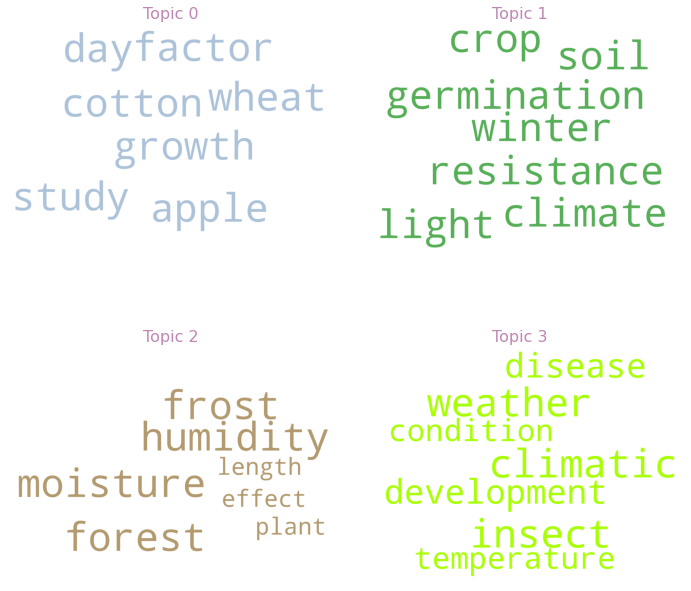

In [29]:
#Generation of wordclouds for each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=7,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16), color="#bf86b4")
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

#save to file
plt.savefig("2Bib_word_clouds_topics")